In [ ]:
# Model Testing
# Samsung Electronics
# Fundametal Features

- 모든 데이터를 불러오기엔 시간 상의 문제로 삼성 전자의 데이터로 테스트 해보겠습니다

모델 구현 출처 : https://ar5iv.labs.arxiv.org/html/2210.12462

In [97]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00


In [56]:
!pip install pykrx

In [162]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tqdm
import networkx as nx
import matplotlib.pyplot as plt

# 삼성전자 데이터 테스트

In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [164]:
from pykrx import stock
from pykrx import bond

In [165]:
ohlcv_df = stock.get_market_ohlcv("20120102", "20231231", '005930')
ohlcv_df.head(3)

,시가,고가,저가,종가,거래량,등락률
날짜,,,,,,
2012-01-02,21400,21600,21300,21600,263300,2.079395
2012-01-03,21860,22100,21840,22100,339046,2.314815
2012-01-04,22100,22200,21500,21600,342389,-2.262443


In [166]:
fund_df = stock.get_market_fundamental("20120102", "20231231", "005930")
print(fund_df.head(2))

               BPS    PER   PBR     EPS   DIV    DPS
날짜                                                  
2012-01-02  623257  10.19  1.73  105992  0.93  10000
2012-01-03  623257  10.43  1.77  105992  0.90  10000


In [167]:
# 이름 변경
ohlcv_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
print(ohlcv_df.head())

             Open   High    Low  Close  Volume    Change
날짜                                                      
2012-01-02  21400  21600  21300  21600  263300  2.079395
2012-01-03  21860  22100  21840  22100  339046  2.314815
2012-01-04  22100  22200  21500  21600  342389 -2.262443
2012-01-05  21460  21580  21100  21100  346691 -2.314815
2012-01-06  21120  21319  20600  20800  376753 -1.421801


In [168]:
ohlcv_df.index.name = 'Date'
fund_df.index.name = 'Date'

print(ohlcv_df.head(3))
print(fund_df.head(3))

             Open   High    Low  Close  Volume    Change
Date                                                    
2012-01-02  21400  21600  21300  21600  263300  2.079395
2012-01-03  21860  22100  21840  22100  339046  2.314815
2012-01-04  22100  22200  21500  21600  342389 -2.262443
               BPS    PER   PBR     EPS   DIV    DPS
Date                                                
2012-01-02  623257  10.19  1.73  105992  0.93  10000
2012-01-03  623257  10.43  1.77  105992  0.90  10000
2012-01-04  623257  10.19  1.73  105992  0.93  10000


In [169]:
old_df = stock.get_market_ohlcv("20110102", "20231231", '005930')
old_df.index.name = 'Date'
old_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
old_df.head(3)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2011-01-03,19100,19320,19000,19160,265562,0.948367
2011-01-04,19120,19219,18980,19160,274488,0.000000
2011-01-05,19100,19100,18840,18840,336224,-1.670146


In [170]:
tech_df = pd.DataFrame(index=ohlcv_df.index)

# 이동 평균 (SMA, EMA)
tech_df['SMA_20'] = old_df['Close'].rolling(window=20).mean()  # 20일 단순 이동 평균
tech_df['EMA_20'] = old_df['Close'].ewm(span=20, adjust=False).mean()  # 20일 지수 이동 평균

# 모멘텀 (Momentum)
tech_df['Momentum_10'] = old_df['Close'] - ohlcv_df['Close'].shift(10)  # 10일 모멘텀

# 상대 강도 지수 (RSI)
delta = old_df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # 14일 동안의 상승폭 평균
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # 14일 동안의 하락폭 평균
rs = gain / loss
tech_df['RSI_14'] = 100 - (100 / (1 + rs))  # RSI 계산

# Bollinger Bands
tech_df['SMA_20'] = old_df['Close'].rolling(window=20).mean()  # 20일 단순 이동 평균 (SMA)
tech_df['STD_20'] = old_df['Close'].rolling(window=20).std()  # 20일 표준 편차
tech_df['Upper_Band'] = tech_df['SMA_20'] + (tech_df['STD_20'] * 2)  # 상단 밴드
tech_df['Lower_Band'] = tech_df['SMA_20'] - (tech_df['STD_20'] * 2)  # 하단 밴드

# MACD
tech_df['EMA_12'] = old_df['Close'].ewm(span=12, adjust=False).mean()  # 12일 지수 이동 평균
tech_df['EMA_26'] = old_df['Close'].ewm(span=26, adjust=False).mean()  # 26일 지수 이동 평균
tech_df['MACD'] = tech_df['EMA_12'] - tech_df['EMA_26']  # MACD 계산
tech_df['Signal_Line'] = tech_df['MACD'].ewm(span=9, adjust=False).mean()  # MACD 신호선

# Average True Range
high_low = old_df['High'] - old_df['Low']
high_close = (old_df['High'] - old_df['Close'].shift()).abs()
low_close = (old_df['Low'] - old_df['Close'].shift()).abs()
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
tech_df['ATR_14'] = true_range.rolling(window=14).mean()  # 14일 평균 진폭

# Volume Moving Average
tech_df['Volume_MA_20'] = old_df['Volume'].rolling(window=20).mean()  # 20일 거래량 이동 평균

print(tech_df.head())


             SMA_20        EMA_20  Momentum_10     RSI_14      STD_20  \
Date                                                                    
2012-01-02  21051.0  20918.649580          NaN  49.212598  421.749489   
2012-01-03  21090.0  21031.159144          NaN  61.224490  479.978070   
2012-01-04  21126.0  21085.334464          NaN  57.692308  490.288851   
2012-01-05  21125.0  21086.731182          NaN  57.692308  490.322128   
2012-01-06  21101.0  21059.423450          NaN  48.979592  494.069034   

              Upper_Band    Lower_Band        EMA_12        EMA_26  \
Date                                                                 
2012-01-02  21894.498978  20207.501022  21133.507442  20741.801639   
2012-01-03  22049.956139  20130.043861  21282.198605  20842.408925   
2012-01-04  22106.577703  20145.422297  21331.091127  20898.526783   
2012-01-05  22105.644257  20144.355743  21295.538646  20913.450725   
2012-01-06  22089.138068  20112.861932  21219.301931  20905.046967  

In [171]:
tech_df.tail()

,SMA_20,EMA_20,Momentum_10,RSI_14,STD_20,Upper_Band,Lower_Band,EMA_12,EMA_26,MACD,Signal_Line,ATR_14,Volume_MA_20
Date,,,,,,,,,,,,,
2023-12-21,72730.0,72890.304232,3500.0,67.857143,1016.754382,74763.508764,70696.491236,73398.086374,72562.259201,835.827173,692.354433,957.142857,12144397.75
2023-12-22,72940.0,73176.941924,3300.0,68.965517,1208.478818,75356.957635,70523.042365,73782.996163,72809.499260,973.496902,748.582927,985.714286,12536343.90
2023-12-26,73205.0,73502.947455,3600.0,83.750000,1396.414582,75997.829164,70412.170836,74216.381368,73090.277093,1126.104275,824.087197,957.142857,12738896.50
2023-12-27,73470.0,73931.238174,4500.0,85.393258,1752.922372,76975.844744,69964.155256,74798.476543,73453.960271,1344.516271,928.173012,1000.000000,13107294.55
2023-12-28,73760.0,74366.358348,5700.0,88.043478,2069.935163,77899.870326,69620.129674,75367.941690,73827.740992,1540.200698,1050.578549,1014.285714,13532974.70


In [172]:
# Market Feature의 생성
!pip install yfinance pandas_datareader

In [173]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime

start_date = '2012-01-01'
end_date = '2023-12-31'

vix_data = yf.download('^VIX', start=start_date, end=end_date)

kospi_data = yf.download('^KS11', start=start_date, end=end_date)

kr_interest_rate = pdr.get_data_fred('IR3TIB01KRM156N', start=start_date, end=end_date)  # 3개월 CD 금리

usdkrw_exchange_rate = pdr.get_data_fred('DEXKOUS', start=start_date, end=end_date)

kr_csi = pdr.get_data_fred('CSCICP03KRM665S', start=start_date, end=end_date)  # 한국 소비자심리지수

market_data = pd.DataFrame({
    'VIX': vix_data['Close'],
    'KOSPI': kospi_data['Close'],
    'KR_Interest_Rate': kr_interest_rate['IR3TIB01KRM156N'],
    'USD_KRW': usdkrw_exchange_rate['DEXKOUS'],
    'KR_CSI': kr_csi['CSCICP03KRM665S']
})

market_data = market_data.dropna()

print(market_data.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                  VIX        KOSPI  KR_Interest_Rate  USD_KRW     KR_CSI
2012-02-01  18.549999  1959.239990              3.53  1126.35  100.03420
2012-06-01  26.660000  1834.510010              3.54  1182.00  100.22230
2012-08-01  18.959999  1879.930054              3.19  1126.56   99.77996
2012-11-01  16.690001  1898.439941              2.85  1090.27   99.74622
2013-02-01  12.900000  1957.790039              2.83  1094.79  100.14550


In [174]:
gdp = pd.read_csv('/content/gdp.csv')
gdp = gdp.T
print(gdp.head())

                                     0
통계표                2.1.1.2. 주요지표(분기지표)
계정항목         국내총생산(GDP)(실질, 계절조정, 전기비)
단위                                  % 
변환                                 원자료
2012/Q1                            1.0


In [175]:
gdp = gdp.iloc[4:]
gdp.columns = ['GDP']

In [176]:
gdp.index.name = 'Date'
gdp.index = gdp.index.str.replace(r'Q1', '03-31').str.replace(r'Q2', '06-30') \
                                .str.replace(r'Q3', '09-30').str.replace(r'Q4', '12-31')

gdp.index = pd.to_datetime(gdp.index)

gdp_daily = gdp.resample('D').ffill()

gdp_daily.index.name = 'Date'

In [177]:
call_rate = pd.read_csv('/content/call_rate.csv')
call_rate = call_rate.T.iloc[4:]

In [178]:
call_rate.columns = ['call_rate']
call_rate

,call_rate
2012/01/02,3.25
2012/01/03,3.25
2012/01/04,3.24
2012/01/05,3.25
2012/01/06,3.25
...,...
2023/12/22,3.638
2023/12/26,3.632
2023/12/27,3.556
2023/12/28,3.6


In [179]:
market_data_combined = market_data.copy()

market_data_combined = pd.merge(market_data_combined, call_rate, left_index=True, right_index=True, how='left')

market_data_combined = pd.merge(market_data_combined, gdp_daily, left_index=True, right_index=True, how='left')

In [180]:
market_df=market_data_combined.copy()
market_df

,VIX,KOSPI,KR_Interest_Rate,USD_KRW,KR_CSI,call_rate,GDP
2012-02-01,18.549999,1959.239990,3.53,1126.35,100.03420,NaN,NaN
2012-06-01,26.660000,1834.510010,3.54,1182.00,100.22230,NaN,1.0
2012-08-01,18.959999,1879.930054,3.19,1126.56,99.77996,NaN,0.4
2012-11-01,16.690001,1898.439941,2.85,1090.27,99.74622,NaN,0.4
2013-02-01,12.900000,1957.790039,2.83,1094.79,100.14550,NaN,0.7
...,...,...,...,...,...,...,...
2023-06-01,15.650000,2569.169922,3.75,1321.35,100.01970,NaN,0.4
2023-08-01,13.930000,2667.070068,3.70,1283.84,100.21360,NaN,0.6
2023-09-01,13.090000,2563.709961,3.76,1318.34,99.97664,NaN,0.6
2023-11-01,16.870001,2301.560059,3.83,1356.94,99.65903,NaN,0.8


In [181]:
print(fund_df.head())
print(tech_df.head())
print(market_df.tail())

               BPS    PER   PBR     EPS   DIV    DPS
Date                                                
2012-01-02  623257  10.19  1.73  105992  0.93  10000
2012-01-03  623257  10.43  1.77  105992  0.90  10000
2012-01-04  623257  10.19  1.73  105992  0.93  10000
2012-01-05  623257   9.95  1.69  105992  0.95  10000
2012-01-06  623257   9.81  1.67  105992  0.96  10000
             SMA_20        EMA_20  Momentum_10     RSI_14      STD_20  \
Date                                                                    
2012-01-02  21051.0  20918.649580          NaN  49.212598  421.749489   
2012-01-03  21090.0  21031.159144          NaN  61.224490  479.978070   
2012-01-04  21126.0  21085.334464          NaN  57.692308  490.288851   
2012-01-05  21125.0  21086.731182          NaN  57.692308  490.322128   
2012-01-06  21101.0  21059.423450          NaN  48.979592  494.069034   

              Upper_Band    Lower_Band        EMA_12        EMA_26  \
Date                                           

In [182]:
from google.colab import files

# CSV 파일로 저장
fund_df.to_csv('fund_df.csv', index=False)
tech_df.to_csv('tech_df.csv', index=False)
market_df.to_csv('market_df.csv', index=False)

# 로컬로 다운로드 시 필요 코드
# files.download('fund_df.csv')
# files.download('tech_df.csv')
# files.download('market_df.csv')

**학습 데이터 피처 표준화 및 데이터 처리**

In [183]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

fundamental_features = fund_df.copy()

technical_features = tech_df.copy()

market_features = market_df.copy()

# 표준화
scaler = StandardScaler()
fundamental_features = pd.DataFrame(scaler.fit_transform(fundamental_features), columns=fundamental_features.columns)
technical_features = pd.DataFrame(scaler.fit_transform(technical_features), columns=technical_features.columns)
market_features = pd.DataFrame(scaler.fit_transform(market_features), columns=market_features.columns)

# 피처 결합
stock_features = pd.concat([fundamental_features, technical_features, market_features], axis=1)
stock_features


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,BPS,PER,PBR,EPS,DIV,DPS,SMA_20,EMA_20,Momentum_10,RSI_14,...,Signal_Line,ATR_14,Volume_MA_20,VIX,KOSPI,KR_Interest_Rate,USD_KRW,KR_CSI,call_rate,GDP
0,0.347201,-0.367729,0.015084,0.369809,-0.832228,0.093433,-1.304126,-1.312857,NaN,-0.175949,...,0.352431,-0.526773,-0.835560,0.120487,-0.839371,1.630494,-0.436540,0.061577,NaN,NaN
1,0.347201,-0.319581,0.124767,0.369809,-0.862312,0.093433,-1.302001,-1.306719,NaN,0.586221,...,0.365040,-0.541337,-0.835315,1.261004,-1.172573,1.641128,0.249080,0.248587,NaN,0.463203
2,0.347201,-0.367729,0.015084,0.369809,-0.832228,0.093433,-1.300040,-1.303764,NaN,0.362100,...,0.373232,-0.525155,-0.835023,0.178146,-1.051239,1.268961,-0.433953,-0.191190,NaN,-0.265431
3,0.347201,-0.415876,-0.094598,0.369809,-0.812173,0.093433,-1.300094,-1.303688,NaN,0.362100,...,0.366550,-0.525155,-0.835310,-0.141086,-1.001792,0.907428,-0.881054,-0.224735,NaN,-0.265431
4,0.347201,-0.443963,-0.149440,0.369809,-0.802145,0.093433,-1.301402,-1.305177,NaN,-0.190734,...,0.343417,-0.515527,-0.836160,-0.674078,-0.843245,0.886161,-0.825366,0.172232,NaN,0.098886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,-0.969166,-0.544271,-0.670433,-0.960874,0.170559,-0.841900,1.511832,1.522227,1.450963,1.007072,...,0.746609,-0.042925,0.559309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2950,-0.969166,-0.522203,-0.643012,-0.960874,0.140475,-0.841900,1.523275,1.537863,1.363451,1.077400,...,0.820330,-0.010560,0.605449,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2951,-0.969166,-0.504147,-0.588171,-0.960874,0.130447,-0.841900,1.537715,1.555647,1.494719,2.015495,...,0.919323,-0.042925,0.629293,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2952,-0.969166,-0.470043,-0.533329,-0.960874,0.090336,-0.841900,1.552154,1.579011,1.888521,2.119762,...,1.055789,0.005622,0.672661,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 데이터 전처리
- 타겟 값 생성
- 훈련 및 테스트 데이터 분리
- 파이토치 텐서 변환 : 데이터를 텐서로 변환하여 파이토치에서 바로 학습할 수 있도록 함

In [184]:
# 데이터 준비
fundamental_features = fund_df.copy()
technical_features = tech_df.copy()
market_features = market_df.copy()

In [185]:
scaler = StandardScaler()
fundamental_features = pd.DataFrame(scaler.fit_transform(fundamental_features), columns=fundamental_features.columns)
technical_features = pd.DataFrame(scaler.fit_transform(technical_features), columns=technical_features.columns)
market_features = pd.DataFrame(scaler.fit_transform(market_features), columns=market_features.columns)

stock_features = pd.concat([fundamental_features, technical_features, market_features], axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [186]:
num_samples = stock_features.shape[0]
y = np.random.randint(0, 2, size=num_samples)

In [187]:
X_train, X_test, y_train, y_test = train_test_split(stock_features, y, test_size=0.2, random_state=42)

# 데이터 텐서 전환
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [188]:
print(f'X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}')

X_train shape: torch.Size([2363, 26]), y_train shape: torch.Size([2363])


In [189]:
# 엣지 생성 위해 티커 체크
for ticker in stock.get_index_ticker_list(market='KOSDAQ'):
    print(ticker, stock.get_index_ticker_name(ticker))

2001 코스닥
2002 코스닥 대형주
2003 코스닥 중형주
2004 코스닥 소형주
2012 기타서비스
2024 제조업
2026 건설
2027 유통
2029 운송
2031 금융
2037 오락·문화
2056 음식료·담배
2058 섬유·의류
2062 종이·목재
2063 출판·매체복제
2065 화학
2066 제약
2067 비금속
2068 금속
2070 기계·장비
2072 일반전기전자
2074 의료·정밀기기
2075 운송장비·부품
2077 기타제조
2181 코스닥 우량기업부
2182 코스닥 벤처기업부
2183 코스닥 중견기업부
2184 코스닥 기술성장기업부
2189 코스닥 글로벌
2203 코스닥 150
2212 코스닥 150 소재
2213 코스닥 150 산업재
2214 코스닥 150 필수소비재
2215 코스닥 150 자유소비재
2216 코스닥 150 정보기술
2217 코스닥 150 헬스케어
2218 코스닥 150 커뮤니케이션서비스


In [190]:
it200 = stock.get_index_ohlcv("20120101", "20231231", "1155")
elec = stock.get_index_ohlcv("20120101", "20231231", "1013")
elec2 = stock.get_index_ohlcv("20120101", "20231231", "2216")
elec3 = stock.get_index_ohlcv("20120101", "20231231", "2072")
print(elec2.head(2))
print(it200.head(2))
print(elec.head(2))
print(elec3.head(2))

코스닥 150 정보기술   시가   고가   저가      종가  거래량  거래대금  상장시가총액
날짜                                                    
2012-01-02    0.0  0.0  0.0  912.21    0     0       0
2012-01-03    0.0  0.0  0.0  923.98    0     0       0
코스피 200 정보기술       시가       고가       저가       종가       거래량           거래대금  \
날짜                                                                          
2012-01-02    1178.74  1195.24  1177.62  1191.26  22502130   934087570725   
2012-01-03    1205.61  1221.30  1205.15  1221.30  20871304  1032452366624   

코스피 200 정보기술           상장시가총액  
날짜                             
2012-01-02    250437084478375  
2012-01-03    256633461227315  
전기전자             시가       고가       저가       종가       거래량          거래대금  \
날짜                                                                       
2012-01-02  8588.71  8692.13  8587.39  8692.11  54996423  956948078095   
2012-01-03  8804.42  8884.67  8797.69  8884.67  57782933  990930537278   

전기전자                 상장시가총액  
날짜              

In [191]:
kospi = stock.get_index_ohlcv("20120101", "20231231", "1001")
kospi_big = stock.get_index_ohlcv("20120101", "20231231", "1002")
kosdaq = stock.get_index_ohlcv("20120101", "20231231", "2001")
kosdaq_big = stock.get_index_ohlcv("20120101", "20231231", "2002")
print(kospi.head(2))
print(kospi_big.head(2))
print(kosdaq.head(2))
print(kosdaq_big.head(2))

코스피              시가       고가       저가       종가        거래량           거래대금  \
날짜                                                                         
2012-01-02  1831.69  1837.81  1814.55  1826.37  323358862  3304263991445   
2012-01-03  1846.56  1875.41  1846.56  1875.41  443474014  4831853886344   

코스피                   상장시가총액  
날짜                            
2012-01-02  1042325072732398  
2012-01-03  1070059481359981  
코스피 대형주          시가       고가       저가       종가       거래량           거래대금  \
날짜                                                                        
2012-01-02  1790.28  1797.62  1773.21  1785.92  51498552  2292853718140   
2012-01-03  1807.22  1838.84  1807.22  1838.84  67886521  3472299243104   

코스피 대형주              상장시가총액  
날짜                           
2012-01-02  845532222969130  
2012-01-03  870602179055420  
코스닥             시가      고가      저가      종가        거래량           거래대금  \
날짜                                                                     
2012-0

In [192]:
import torch

closing_prices = pd.DataFrame({
    'it200': it200['종가'],
    'elec': elec['종가'],
    'elec2': elec2['종가'],
    'elec3': elec3['종가'],
    'kospi': kospi['종가'],
    'kospi_big': kospi_big['종가'],
    'kosdaq': kosdaq['종가'],
    'kosdaq_big': kosdaq_big['종가']
})

# 결측치 처리
closing_prices.fillna(method='ffill', inplace=True)

# 일간 수익률
returns = closing_prices.pct_change().dropna()

# 상관계수 계산
correlation_matrix = returns.corr()

# 텐서 전환
correlation_tensor = torch.tensor(correlation_matrix.values, dtype=torch.float32)

# 산업별 종목 (IT 관련)
industry_columns = ['it200', 'elec', 'elec2', 'elec3']
market_columns = ['kospi', 'kospi_big', 'kosdaq', 'kosdaq_big']

# 산업별 엣지 생성 (산업 내 상관관계가 높은 엣지 생성)
industry_edges = []
for i, col1 in enumerate(industry_columns):
    for j, col2 in enumerate(industry_columns):
        if i != j and correlation_matrix.loc[col1, col2] > 0.5:  # 상관계수 임계값 0.5 설정
            industry_edges.append([i, j])

# 시장 엣지 생성 (시장 내 상관관계가 높은 엣지 생성)
market_edges = []
for i, col1 in enumerate(market_columns):
    for j, col2 in enumerate(market_columns):
        if i != j and correlation_matrix.loc[col1, col2] > 0.5:  # 상관계수 임계값 0.5 설정
            market_edges.append([i + len(industry_columns), j + len(industry_columns)])  # 인덱스를 맞춰서 추가

# 산업별 엣지 정보 출력
industry_edge_tensor = torch.tensor(industry_edges, dtype=torch.long).t().contiguous()
print("산업별 엣지 정보:", industry_edge_tensor)

# 시장 엣지 정보 출력
market_edge_tensor = torch.tensor(market_edges, dtype=torch.long).t().contiguous()
print("시장 엣지 정보:", market_edge_tensor)

# 엣지 정보 결합
combined_edge_tensor = torch.cat([industry_edge_tensor, market_edge_tensor], dim=1)
print("결합된 엣지 정보:", combined_edge_tensor)


산업별 엣지 정보: tensor([[0, 0, 1, 1, 2, 2, 2, 3],
        [1, 2, 0, 2, 0, 1, 3, 2]])
시장 엣지 정보: tensor([[4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7],
        [5, 6, 7, 4, 6, 7, 4, 5, 7, 4, 5, 6]])
결합된 엣지 정보: tensor([[0, 0, 1, 1, 2, 2, 2, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7],
        [1, 2, 0, 2, 0, 1, 3, 2, 5, 6, 7, 4, 6, 7, 4, 5, 7, 4, 5, 6]])


<ipython-input-192-f5ef4a27802b>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  closing_prices.fillna(method='ffill', inplace=True)


In [193]:
# 노드 수 계산
num_nodes = closing_prices.shape[1]

valid_indices = combined_edge_tensor[0] < num_nodes  # 유효한 엣지의 인덱스만 추출
combined_edge_tensor = combined_edge_tensor[:, valid_indices]  # 유효한 엣지들만 남김

# 수정된 엣지 정보 출력
print("수정된 엣지 정보:", combined_edge_tensor)


수정된 엣지 정보: tensor([[0, 0, 1, 1, 2, 2, 2, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7],
        [1, 2, 0, 2, 0, 1, 3, 2, 5, 6, 7, 4, 6, 7, 4, 5, 7, 4, 5, 6]])


## 모델 학습 진행
- 모델 구조는 StockContextEncoder를 유지
- 입력 데이터를 은닉 공간으로 변환하고, 이를 바탕으로 최종 예측을 진행하는 방식으로 수행됨
- Stock Context Encoder, Industry 및 Universe Influence, Multi-Head Output, 복합 손실 함수, 피처 중요도 시각화까지 포함

In [194]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 재무 비율, 기술적 분석 데이터, OHLCV 데이터 결합
fundamental_features = fund_df.copy()
technical_features = tech_df.copy()
ohlcv_data = ohlcv_df.copy()

# 피처 결합 (재무비율, 기술적 분석, OHLCV)
stock_features = pd.concat([fundamental_features, technical_features, ohlcv_data], axis=1)

# 결측치 처리 (평균값으로 채우기)
stock_features_filled = stock_features.fillna(stock_features.mean())

# 피처 표준화
scaler = StandardScaler()
stock_features_scaled = pd.DataFrame(scaler.fit_transform(stock_features_filled), columns=stock_features_filled.columns)

X_train, X_test, y_train, y_test = train_test_split(stock_features_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [195]:
closing_prices = pd.DataFrame({
    'it200': it200['종가'],
    'elec': elec['종가'],
    'elec2': elec2['종가'],
    'elec3': elec3['종가'],
    'kospi': kospi['종가'],
    'kospi_big': kospi_big['종가'],
    'kosdaq': kosdaq['종가'],
    'kosdaq_big': kosdaq_big['종가']
})

closing_prices.fillna(method='ffill', inplace=True)  # 결측치 처리
returns = closing_prices.pct_change().dropna()  # 수익률 계산

# 상관계수 계산 및 텐서로 변환
correlation_matrix = returns.corr()
correlation_tensor = torch.tensor(correlation_matrix.values, dtype=torch.float32)

# 산업별 및 시장별 엣지 생성
industry_columns = ['it200', 'elec', 'elec2', 'elec3']
market_columns = ['kospi', 'kospi_big', 'kosdaq', 'kosdaq_big']

# 산업별 엣지 생성
industry_edges = []
for i, col1 in enumerate(industry_columns):
    for j, col2 in enumerate(industry_columns):
        if i != j and correlation_matrix.loc[col1, col2] > 0.5:
            industry_edges.append([i, j])

# 시장 엣지 생성
market_edges = []
for i, col1 in enumerate(market_columns):
    for j, col2 in enumerate(market_columns):
        if i != j and correlation_matrix.loc[col1, col2] > 0.5:
            market_edges.append([i + len(industry_columns), j + len(industry_columns)])

industry_edge_tensor = torch.tensor(industry_edges, dtype=torch.long).t().contiguous()
market_edge_tensor = torch.tensor(market_edges, dtype=torch.long).t().contiguous()
combined_edge_tensor = torch.cat([industry_edge_tensor, market_edge_tensor], dim=1)

<ipython-input-195-9c85b2147805>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  closing_prices.fillna(method='ffill', inplace=True)  # 결측치 처리


1. Stock Context Encoder (StockContextEncoder 클래스)
역할: 주식 데이터의 피처를 처리하는 인코더로, 입력된 피처 데이터를 MLP(Multi-Layer Perceptron)와 배치 정규화를 통해 중간 은닉 공간으로 변환함
- MLP: 입력된 데이터를 다층 퍼셉트론으로 처리해 고차원 피처로 변환함
- Batch Normalization: 학습을 안정화하기 위해 배치 정규화를 적용

In [196]:
# StockContextEncoder 수정
class StockContextEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(StockContextEncoder, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

    def forward(self, x):
        # 입력 데이터 확인
        print(f"Input shape: {x.shape}")
        if len(x.shape) != 2:
            x = x.view(x.size(0), -1)
        x = self.batch_norm(x)
        x = self.mlp(x)
        return x

2. Industry and Universe Influence (IndustryAndUniverseInfluence 클래스)
- 주식이 속한 산업 내 주식 간의 관계와 전체 시장 내 주식 간의 관계를 학습함
- Industry Influence: GATConv 레이어를 통해 산업 내 주식들의 상호작용을 학습함
- Universe Influence: GATConv 레이어를 통해 전체 시장 내 주식들의 상호작용을 학습하고, 이를 바탕으로 산업과 시장의 영향을 제거한 피처를 생성함

3. Multi-Head Output (MultiHeadOutput 클래스)
- 여러 기간에 대한 예측을 동시에 수행하기 위해 다중 출력 헤드를 사용함
- num_heads=5로 설정되어, 5개의 출력 값을 동시에 학습하게 됨
: 각 헤드는 각각 다른 기간에 대한 예측을 담당함

4. FullModel (FullModel 클래스)
- 전체 모델을 정의하는 클래스로, 입력된 데이터를 인코딩하고, 산업 및 전체 시장 영향을 반영한 후, 다중 출력 헤드를 통해 각 기간의 예측값을 생성함
- StockContextEncoder로 피처 데이터를 인코딩하고,
- IndustryAndUniverseInfluence를 통해 산업 및 시장 영향을 학습함
최종적으로 MultiHeadOutput을 통해 여러 기간의 예측을 동시에 수행함

In [197]:
class IndustryAndUniverseInfluence(nn.Module):
    def __init__(self, in_feats, hidden_size, num_heads):
        super(IndustryAndUniverseInfluence, self).__init__()
        self.industry_gat = GATConv(in_feats, hidden_size, heads=num_heads, concat=False)
        self.universe_gat = GATConv(hidden_size, hidden_size, heads=num_heads, concat=False)

    def forward(self, x, edge_index_industry, edge_index_universe):
        industry_influence = self.industry_gat(x, edge_index_industry)
        industry_neutralized = x - industry_influence
        universe_influence = self.universe_gat(industry_neutralized, edge_index_universe)
        return industry_neutralized - universe_influence

class FullModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_heads):
        super(FullModel, self).__init__()
        self.context_encoder = StockContextEncoder(input_size, hidden_size)
        self.influence_module = IndustryAndUniverseInfluence(hidden_size, hidden_size, num_heads)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index_industry, edge_index_universe):
        encoded_x = self.context_encoder(x)
        final_representation = self.influence_module(encoded_x, edge_index_industry, edge_index_universe)
        output = self.fc(final_representation)
        return output

5. 손실 함수 정의 (custom_loss 함수)
- 분류 손실과 더불어 Factor Stability와 Factor Returns 손실을 포함한 복합 손실 함수를 정의함
- Factor Stability Loss: 안정성 측정 지표를 반영한 손실.
- Factor Returns Loss: 예측된 요인 수익률을 반영한 손실.
- CrossEntropy Loss: 기본적인 분류 문제의 손실을 포함한 복합 손실 함수

In [198]:
from torch_geometric.nn import GATConv  # PyTorch Geometric의 GATConv 모듈

In [199]:
# 손실 함수 정의
def custom_loss(outputs, targets, stability_factor, factor_returns):
    stability_loss = stability_factor.mean()
    returns_loss = factor_returns.mean()
    criterion = nn.CrossEntropyLoss()
    classification_loss = criterion(outputs, targets)
    return classification_loss - stability_loss - returns_loss

# 학습 루프
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    model.train()
    outputs = model(X_train_tensor, industry_edge_tensor, market_edge_tensor)
    loss = custom_loss(outputs, y_train_tensor, torch.randn(1), torch.randn(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Epoch [10/100], Loss: 2.8820
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Epoch [20/100], Loss: -0.2731
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input

In [200]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# 모델 평가 함수 설정
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor, industry_edge_tensor, market_edge_tensor)
    predicted = outputs.argmax(dim=1)

    accuracy = (predicted == y_test_tensor).float().mean().item()
    print(f'Accuracy: {accuracy * 100:.2f}%')

    precision = precision_score(y_test_tensor.cpu(), predicted.cpu(), average='weighted')
    print(f'Precision: {precision:.4f}')

    recall = recall_score(y_test_tensor.cpu(), predicted.cpu(), average='weighted')
    print(f'Recall: {recall:.4f}')

    f1 = f1_score(y_test_tensor.cpu(), predicted.cpu(), average='weighted')
    print(f'F1 Score: {f1:.4f}')

    cm = confusion_matrix(y_test_tensor.cpu(), predicted.cpu())
    print('Confusion Matrix:')
    print(cm)

Input shape: torch.Size([591, 25])
Accuracy: 49.75%
Precision: 0.5034
Recall: 0.4975
F1 Score: 0.4987
Confusion Matrix:
[[159 166]
 [131 135]]


In [201]:
from sklearn.model_selection import ParameterGrid
import torch.optim as optim

param_grid = {
    'hidden_size': [16, 32, 64],
    'num_heads': [2, 4, 6],
    'lr': [0.001, 0.01, 0.0001]
}

def train_model_with_params(params, X_train, y_train, X_test, y_test, industry_edge_tensor, market_edge_tensor, epochs=50):
    hidden_size = params['hidden_size']
    num_heads = params['num_heads']
    lr = params['lr']

    model = FullModel(input_size, hidden_size, output_size, num_heads)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        outputs = model(X_train, industry_edge_tensor, market_edge_tensor)
        loss = custom_loss(outputs, y_train, torch.randn(1), torch.randn(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        outputs = model(X_test, industry_edge_tensor, market_edge_tensor)
        predicted = outputs.argmax(dim=1)
        accuracy = (predicted == y_test).float().mean().item()
    return accuracy

best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    accuracy = train_model_with_params(params, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, industry_edge_tensor, market_edge_tensor)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy:.4f}")

Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Epoch [10/50], Loss: 1.7913
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Epoch [20/50], Loss: 2.7706
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input sh

# KFOLD를 활용한 튜닝

In [202]:
from sklearn.model_selection import KFold
import torch.optim as optim
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# KFold 설정 (5 폴드 교차 검증)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 파라미터 그리드 설정
param_grid = {
    'hidden_size': [16, 32, 64],
    'num_heads': [2, 4, 6],
    'lr': [0.001, 0.01, 0.0001]
}

# 모델 학습 및 검증 함수
def train_model_with_params(params, X_train, y_train, X_test, y_test, industry_edge_tensor, market_edge_tensor, epochs=50):
    hidden_size = params['hidden_size']
    num_heads = params['num_heads']
    lr = params['lr']

    model = FullModel(input_size, hidden_size, output_size, num_heads)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 학습 루프
    for epoch in range(epochs):
        model.train()
        outputs = model(X_train, industry_edge_tensor, market_edge_tensor)
        loss = custom_loss(outputs, y_train, torch.randn(1), torch.randn(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 모델 평가
    model.eval()
    with torch.no_grad():
        outputs = model(X_test, industry_edge_tensor, market_edge_tensor)
        predicted = outputs.argmax(dim=1)
        accuracy = (predicted == y_test).float().mean().item()
    return accuracy, model

# 성능 저장용 리스트
tuning_results = []

# 교차 검증 및 파라미터 튜닝
for params in ParameterGrid(param_grid):
    accuracies = []
    f1_scores = []
    precisions = []
    recalls = []

    for train_index, val_index in kfold.split(X_train_tensor, y_train_tensor):
        X_train_fold, X_val_fold = X_train_tensor[train_index], X_train_tensor[val_index]
        y_train_fold, y_val_fold = y_train_tensor[train_index], y_train_tensor[val_index]

        accuracy, model = train_model_with_params(params, X_train_fold, y_train_fold, X_val_fold, y_val_fold, industry_edge_tensor, market_edge_tensor)
        accuracies.append(accuracy)

        # 추가 평가 지표 계산 (Precision, Recall, F1 Score)
        with torch.no_grad():
            outputs = model(X_val_fold, industry_edge_tensor, market_edge_tensor)
            predicted = outputs.argmax(dim=1)
            precision = precision_score(y_val_fold.cpu(), predicted.cpu())
            recall = recall_score(y_val_fold.cpu(), predicted.cpu())
            f1 = f1_score(y_val_fold.cpu(), predicted.cpu())

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)

    tuning_results.append({
        'params': params,
        'accuracy': avg_accuracy,
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    })

# 최적 파라미터 출력
best_result = max(tuning_results, key=lambda x: x['accuracy'])
print(f"Best Params: {best_result['params']}, Best Accuracy: {best_result['accuracy']:.4f}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([472, 25])
Input shape: torch.Size([472, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891, 25])
Input shape: torch.Size([1891,

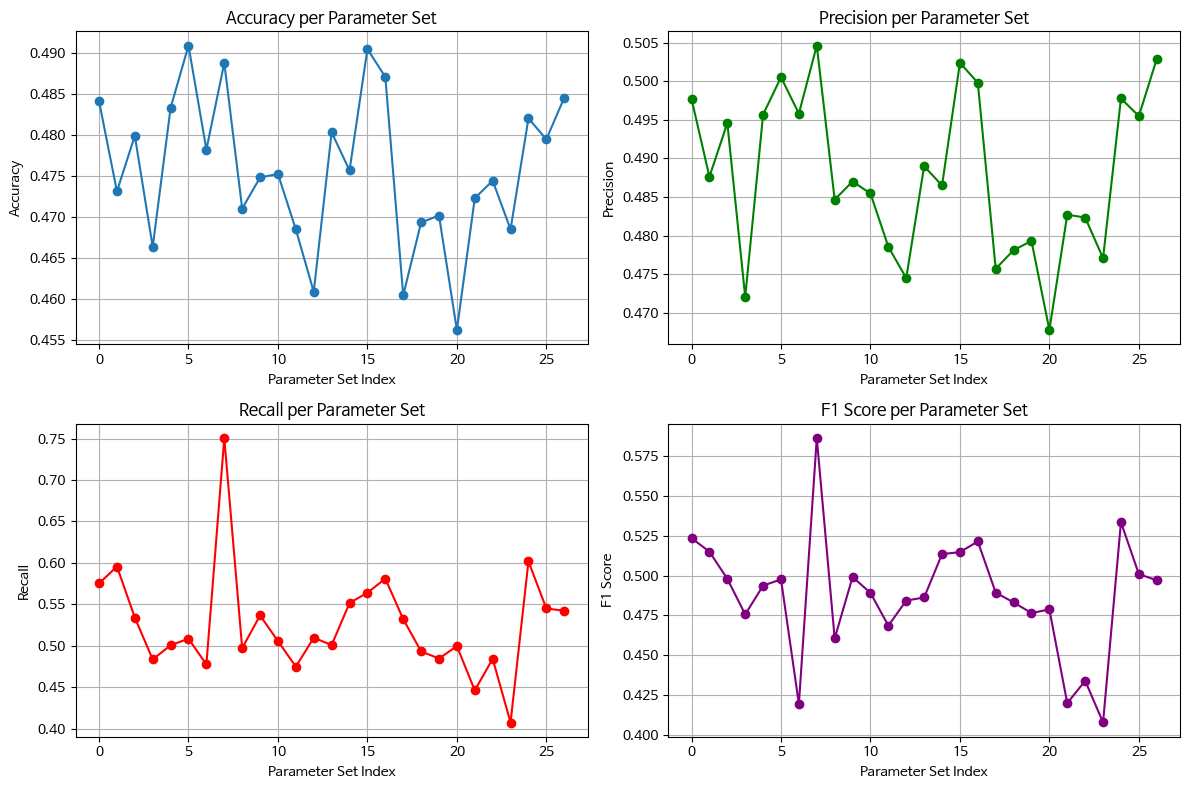

In [203]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = pd.DataFrame(tuning_results)

def plot_tuning_results(results_df):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(results_df.index, results_df['accuracy'], marker='o', label='Accuracy')
    plt.title('Accuracy per Parameter Set')
    plt.xlabel('Parameter Set Index')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(results_df.index, results_df['precision'], marker='o', color='green', label='Precision')
    plt.title('Precision per Parameter Set')
    plt.xlabel('Parameter Set Index')
    plt.ylabel('Precision')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(results_df.index, results_df['recall'], marker='o', color='red', label='Recall')
    plt.title('Recall per Parameter Set')
    plt.xlabel('Parameter Set Index')
    plt.ylabel('Recall')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(results_df.index, results_df['f1'], marker='o', color='purple', label='F1 Score')
    plt.title('F1 Score per Parameter Set')
    plt.xlabel('Parameter Set Index')
    plt.ylabel('F1 Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 그래프 시각화 실행
plot_tuning_results(results_df)

# **Modeling Conclusions**
1. 데이터 준비 및 전처리
  : 주식 데이터의 피처와 타겟 값을 학습 모델에서 사용할 수 있도록 준비하고, 이를 훈련 데이터와 테스트 데이터로 분리한 후 PyTorch 텐서로 변환하는 과정입니다.

  - stock_features: 주식의 다양한 피처 데이터를 정리.
  - y: 예측하고자 하는 타겟 데이터 (예: 상승/하락 여부).
  - train_test_split: 데이터를 훈련 데이터와 테스트 데이터로 80:20 비율로 분리.
  분리된 데이터를 PyTorch 텐서로 변환하여 딥러닝 모델에 입력으로 사용.

2. 모델 설계
  : 주식 데이터를 기반으로 예측을 수행하는 Graph Attention Network (GAT) 기반의 딥러닝 모델을 설계.

  - Stock Context Encoder: 입력된 주식 피처를 다층 퍼셉트론(MLP)으로 인코딩하는 부분.
  - Industry and Universe Influence: 주식들이 속한 산업 간 및 시장 전체 간의 관계를 그래프 기반으로 학습.
  - Multi-Head Output: 여러 기간에 대한 예측을 동시에 수행하는 출력 구조.
  - Full Model: 전체적인 인코딩과 그래프 기반 학습, 그리고 출력이 연결된 완전한 모델.

3. 손실 함수 설계
  : 예측한 결과를 평가하기 위한 손실 함수 정의.

  - Classification Loss: CrossEntropyLoss를 사용해 주식의 상승/하락 여부를 예측하는 분류 손실.
  - Factor Stability Loss와 Factor Returns Loss: 요인 분석에서 안정성 및 수익률과 관련된 손실을 포함한 커스텀 손실 함수.

4. 모델 학습
  : 주어진 훈련 데이터를 사용해 모델을 학습시키는 과정.
  - Forward pass: 훈련 데이터를 모델에 입력하고 예측값을 얻음.
  - Backward pass: 손실을 계산하고 역전파(Backpropagation)를 통해 모델의 가중치를 업데이트.
  - Adam optimizer를 사용하여 학습 과정 최적화.

5. 모델 평가
  : 테스트 데이터로 모델의 성능을 평가.

  모델 평가 모드로 전환한 후 테스트 데이터를 사용해 예측을 수행.
  예측값과 실제값을 비교해 **정확도(accuracy)**를 계산.

6. 어텐션 가중치 시각화
  : 학습된 모델이 주식 피처에서 어떤 피처에 더 많은 주의를 기울였는지 시각적으로 확인.

# 파라미터 튜닝


*   학습률 (Learning Rate): optimizer에서 사용하는 학습률. 너무 크면 학습이 불안정하고, 너무 작으면 학습이 느려짐.
* 은닉층 크기 (Hidden Size): StockContextEncoder와 GAT 레이어의 은닉 크기.
* GAT의 헤드 수 (Number of Heads): 각 GAT 레이어에서 사용하는 어텐션 헤드 수.
* 드롭아웃 비율 (Dropout): 학습 중 과적합을 방지하기 위해 일부 뉴런을 무작위로 비활성화하는 비율.
* 배치 크기 (Batch Size): 학습 시 한 번에 처리할 데이터의 크기.
* 에포크 수 (Epochs): 모델을 학습하는 전체 반복 횟수.



1. Cross-sectional Optimizer:
- 각 시간 t에서 요인 수익률(factor returns)을 학습하기 위해 **MSE(Mean Squared Error)**를 최소화.
- 주어진 시점에서의 요인 수익률을 추정하고, 이를 통해 주식 간의 관계를 학습합니다.
2. Global Optimizer:
- 모델 전체(피처 인코딩, 산업 및 전체 시장 영향 학습, 다중 출력 모듈 등)를 학습.
- 모델 전체의 파라미터를 학습하고 업데이트합니다.


---


* Cross-sectional optimizer: 주식의 **요인 수익률(factor returns)**을 학습하기 위해 SGD를 사용해 손실을 최소화합니다. 주로 Multi-Head Output 레이어에서 사용되며, 각 시점에 대한 예측을 최적화합니다.
* Global optimizer: 모델 전체의 파라미터를 업데이트하는 Adam 옵티마이저를 사용합니다. Stock Context Encoder, Industry and Universe Influence 등의 파라미터가 학습됩니다.
* 두 옵티마이저의 병행 사용: 한 번의 forward pass 후, 두 옵티마이저를 사용하여 각각의 목적을 가진 손실 함수를 최소화합니다.

In [117]:
from sklearn.model_selection import ParameterGrid
import torch.optim as optim

# 파라미터 그리드 설정
param_grid = {
    'hidden_size': [16, 32, 64],
    'num_heads': [2, 4, 6],
    'lr': [0.001, 0.01, 0.0001]
}

# 모델 학습 및 검증 함수
def train_model_with_params(params, X_train, y_train, X_test, y_test, industry_edge_tensor, market_edge_tensor, epochs=50):
    hidden_size = params['hidden_size']
    num_heads = params['num_heads']
    lr = params['lr']

    model = FullModel(input_size, hidden_size, output_size, num_heads)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 학습 루프
    for epoch in range(epochs):
        model.train()
        outputs = model(X_train, industry_edge_tensor, market_edge_tensor)
        loss = custom_loss(outputs, y_train, torch.randn(1), torch.randn(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 모델 평가
    model.eval()
    with torch.no_grad():
        outputs = model(X_test, industry_edge_tensor, market_edge_tensor)
        predicted = outputs.argmax(dim=1)
        accuracy = (predicted == y_test).float().mean().item()
    return accuracy

# 랜덤 서치 실행
best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    accuracy = train_model_with_params(params, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, industry_edge_tensor, market_edge_tensor)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

if best_params is None:
    print("No best parameters found. Check your parameter grid or model training function.")
else:
    print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy:.4f}")

Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([236

In [118]:
import pandas as pd

# 최적의 파라미터로 모델 학습
best_hidden_size = best_params['hidden_size']
best_num_heads = best_params['num_heads']
best_lr = best_params['lr']

# 최적의 파라미터를 반영한 모델 생성 및 학습
best_model = FullModel(input_size, best_hidden_size, output_size, best_num_heads)
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)

# 모델 학습 과정 (에포크는 적절한 값으로 설정)
epochs = 100
for epoch in range(epochs):
    best_model.train()
    outputs = best_model(X_train_tensor, industry_edge_tensor, market_edge_tensor)
    loss = custom_loss(outputs, y_train_tensor, torch.randn(1), torch.randn(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 테스트 데이터에 대한 예측 실행
best_model.eval()
with torch.no_grad():
    outputs = best_model(X_test_tensor, industry_edge_tensor, market_edge_tensor)
    predicted = outputs.argmax(dim=1)

# 예측 결과를 데이터프레임으로 변환
predicted_df = pd.DataFrame({
    'Actual': y_test_tensor.cpu().numpy(),  # 실제 값
    'Predicted': predicted.cpu().numpy()    # 예측 값
})

# 결과 데이터프레임 출력
print(predicted_df.head())  # 처음 몇 개의 결과를 출력

Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([2363, 25])
Input shape: torch.Size([236